##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-training float16 quantization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_float16_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

[TensorFlow Lite](https://www.tensorflow.org/lite/) now supports
converting weights to 16-bit floating point values during model conversion from TensorFlow to TensorFlow Lite's flat buffer format. This results in a 2x reduction in model size. Some hardware, like GPUs, can compute natively in this reduced precision arithmetic, realizing a speedup over traditional floating point execution. The Tensorflow Lite GPU delegate can be configured to run in this way. However, a model converted to float16 weights can still run on the CPU without additional modification: the float16 weights are upsampled to float32 prior to the first inference. This permits a significant reduction in model size in exchange for a minimal impacts to latency and accuracy.

In this tutorial, you train an MNIST model from scratch, check its accuracy in TensorFlow, and then convert the model into a Tensorflow Lite flatbuffer
with float16 quantization. Finally, check the accuracy of the converted model and compare it to the original float32 model.

## Build an MNIST model

### Setup

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

2024-07-19 11:34:48.977108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 11:34:48.998222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 11:34:49.004447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Train and export the model

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


I0000 00:00:1721388892.105621   27336 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388892.109010   27336 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388892.112658   27336 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388892.116353   27336 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

I0000 00:00:1721388895.016331   27503 service.cc:146] XLA service 0x7f34c00072f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721388895.016379   27503 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388895.016384   27503 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388895.016387   27503 service.cc:154]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388895.016393   27503 service.cc:154]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 56:50 2s/step - accuracy: 0.0625 - loss: 2.2976

  32/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2626 - loss: 2.1448  

  68/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4289 - loss: 1.8982

 104/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5181 - loss: 1.6861

I0000 00:00:1721388896.205626   27503 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 140/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5754 - loss: 1.5228

 176/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6162 - loss: 1.3966

 212/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6470 - loss: 1.2965

 248/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6705 - loss: 1.2161

 285/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6897 - loss: 1.1484

 322/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7056 - loss: 1.0913

 358/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7189 - loss: 1.0435

 394/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7304 - loss: 1.0019

 433/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7412 - loss: 0.9625

 471/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7506 - loss: 0.9284

 509/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7588 - loss: 0.8980

 545/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7659 - loss: 0.8717

 582/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7725 - loss: 0.8470

 618/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7784 - loss: 0.8250

 654/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7838 - loss: 0.8046

 690/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7889 - loss: 0.7857

 727/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7936 - loss: 0.7677

 763/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7979 - loss: 0.7514

 799/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8019 - loss: 0.7361

 835/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8057 - loss: 0.7219

 872/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.7082

 908/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8126 - loss: 0.6957

 944/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8157 - loss: 0.6839

 980/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8186 - loss: 0.6727

1015/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8213 - loss: 0.6623

1051/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8240 - loss: 0.6522

1087/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8265 - loss: 0.6426

1123/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8289 - loss: 0.6334

1160/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8313 - loss: 0.6243

1196/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8335 - loss: 0.6158

1232/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8357 - loss: 0.6077

1268/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8377 - loss: 0.5999

1304/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8397 - loss: 0.5924

1339/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8415 - loss: 0.5854

1375/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8434 - loss: 0.5784

1411/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8451 - loss: 0.5716

1446/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8468 - loss: 0.5653

1483/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8485 - loss: 0.5588

1519/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8501 - loss: 0.5527

1557/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8517 - loss: 0.5465

1596/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8534 - loss: 0.5404

1632/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8548 - loss: 0.5349

1668/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8562 - loss: 0.5296

1705/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8576 - loss: 0.5243

1740/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8589 - loss: 0.5194

1775/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8602 - loss: 0.5147

1811/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8615 - loss: 0.5100

1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8627 - loss: 0.5054

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8636 - loss: 0.5017 - val_accuracy: 0.9670 - val_loss: 0.1184


For the example, you trained the model for just a single epoch, so it only trains to ~96% accuracy.

### Convert to a TensorFlow Lite model

Using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), you can now convert the trained model into a TensorFlow Lite model.

Now load the model using the `TFLiteConverter`:

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmptpiyuekm/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmptpiyuekm/assets


Saved artifact at '/tmpfs/tmp/tmptpiyuekm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139872593360672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872593360496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872593465760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872593465584: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1721388900.467583   27336 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388900.467610   27336 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


Write it out to a `.tflite` file:

In [5]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [6]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84668

To instead quantize the model to float16 on export, first set the `optimizations` flag to use default optimizations. Then specify that float16 is the supported type on the target platform:

In [7]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.

In [8]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"mnist_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp3hgfoneq/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp3hgfoneq/assets


Saved artifact at '/tmpfs/tmp/tmp3hgfoneq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139872593360672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872593360496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872593465760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872593465584: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1721388900.806469   27336 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388900.806496   27336 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


44388

Note how the resulting file is approximately `1/2` the size.

In [9]:
!ls -lh {tflite_models_dir}

total 184K
-rw-rw-r-- 1 kbuilder kbuilder 83K Jul 19 11:35 mnist_model.tflite
-rw-rw-r-- 1 kbuilder kbuilder 25K Jul 19 11:31 mnist_model_quant.tflite
-rw-rw-r-- 1 kbuilder kbuilder 25K Jul 19 11:33 mnist_model_quant_16x8.tflite
-rw-rw-r-- 1 kbuilder kbuilder 44K Jul 19 11:35 mnist_model_quant_f16.tflite


## Run the TensorFlow Lite models

Run the TensorFlow Lite model using the Python TensorFlow Lite Interpreter.

### Load the model into the interpreters

In [10]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

### Test the models on one image

In [12]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

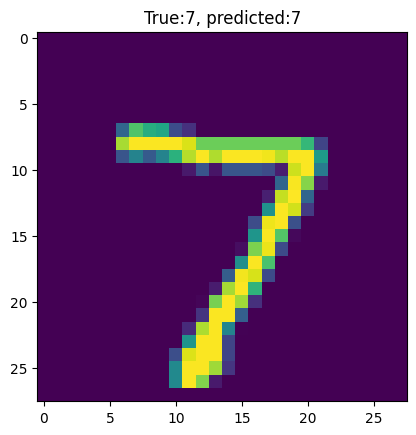

In [13]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [14]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictions = interpreter_fp16.get_tensor(output_index)

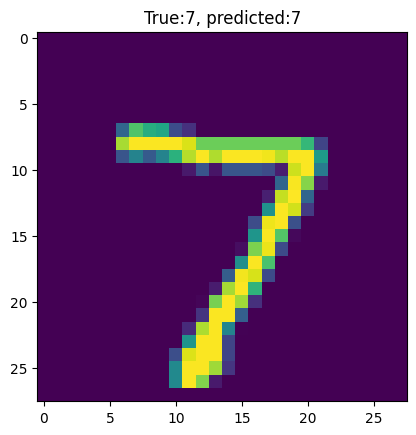

In [15]:
plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### Evaluate the models

In [16]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [17]:
print(evaluate_model(interpreter))

0.967


Repeat the evaluation on the float16 quantized model to obtain:

In [18]:
# NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite
# doesn't have super optimized server CPU kernels. For this reason this may be
# slower than the above float interpreter. But for mobile CPUs, considerable
# speedup can be observed.
print(evaluate_model(interpreter_fp16))

0.9671


In this example, you have quantized a model to float16 with no difference in the accuracy.

It's also possible to evaluate the fp16 quantized model on the GPU. To perform all arithmetic with the reduced precision values, be sure to create the `TfLiteGPUDelegateOptions` struct in your app and set `precision_loss_allowed` to `1`, like this:

```
//Prepare GPU delegate.
const TfLiteGpuDelegateOptions options = {
  .metadata = NULL,
  .compile_options = {
    .precision_loss_allowed = 1,  // FP16
    .preferred_gl_object_type = TFLITE_GL_OBJECT_TYPE_FASTEST,
    .dynamic_batch_enabled = 0,   // Not fully functional yet
  },
};
```

Detailed documentation on the TFLite GPU delegate and how to use it in your application can be found [here](https://www.tensorflow.org/lite/performance/gpu_advanced?source=post_page---------------------------)